# we have the data now we have to put it into the model

In [3]:
#the key is we will just use the data and load it in
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import argparse
from src.dataloaders.datasets.general_dataset import GeneralDataset
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import EnformerDecoder
from src.tasks.encoders import JointCNN
from caduceus.configuration_caduceus import CaduceusConfig
import yaml
from omegaconf import OmegaConf
import itertools
import inspect
import zarr
from numcodecs import Blosc
from scipy.stats import spearmanr, pearsonr
from torch.utils.data import DataLoader
import pickle

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")

class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 device = None,
                 load_data=False,
                 **dataset_overrides #Don't pass None into overrides unless you intentionally want it to be None! Pass in items only that you need
                 ) -> None:
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        
        state_dict = torch.load(ckpt_path, map_location='cpu')
        if device is not None:
            #if we are given a device, we will use that device
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.split = split

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            sig = inspect.signature(GeneralDataset.__init__)
            sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
            to_remove = []
            for k, v in dataset_args.items():
                if k not in sig:
                    # del dataset_args[k]
                    to_remove.append(k)
            for k in to_remove:
                del dataset_args[k]
            dataset_args['split'] = split
            dataset_args['evaluating'] = True #this tells it to not do things like random shifting and rc aug, still does random masking tho, can get og sequence easily
            dataset_args['load_in'] = load_data
            
            for k, v in dataset_overrides.items():
                if k in sig:
                    dataset_args[k] = v
                    print(f"Overriding {k} with {v}")
                else:
                    print(f"Warning: {k} not in dataset args, skipping")
            
            # dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset_args = dataset_args
            # self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset = GeneralDataset(**dataset_args)
            
            # self.kmer_len = dataset_args['kmer_len']
            # self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
            #                                                 return_CAGE=dataset_args['return_CAGE'], cell_type=dataset_args.get('cell_type', None),
            #                                                 kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        cfg['model']['config'].pop('_target_')
        # cfg['model']['config']['complement_map'] = self.dataset.tokenizer.complement_map
        caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
        
        self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.cfg['decoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.decoder = EnformerDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        del self.cfg['encoder']['_name_']
        self.cfg['encoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.encoder = JointCNN(**self.cfg['encoder'])
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()
        
    def __call__(self, idx=None, data=None):
        #now evaluate the model on one example
        if data is None:
            (seq,acc),(seq_unmask,acc_unmask) = self.dataset[idx]
            
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
        else:
            (x,y),(seq_unmask,acc_unmask) = data

            if x.dim() == 2:
                x = x.unsqueeze(0) #add batch dim
                y = y.unsqueeze(0) #add batch dim
        
        x,y = x.to(self.device), y.to(self.device)
        
        with torch.no_grad():
            x1 = self.encoder(x,y)
            x1,_ = self.backbone(x1)
            x1 = self.decoder(x1)
        
        return x1

In [4]:
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-05-08/16-33-43-098345/checkpoints/03-val_loss=-0.45033.ckpt'
data_path = '/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz'
evals = Evals(ckpt_path,load_data=True, data_path=data_path, additional_data=None, additional_data_idxs=None)

Overriding data_path with /data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz
Overriding additional_data with None
Overriding additional_data_idxs with None
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [ ]:
len(evals.dataset) #I think it's correct as it uses all the same arguments, just doesn't load additional data

1937

In [6]:
out = evals.dataset[0]
print(len(out[1]))

2


In [7]:
#yup doens't return the additional data, just the sequence and doesn't even mask it here since it's just correct! Let's make sure it's not masked tho

evals.dataset_args

{'data_path': '/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
 'length': 524288,
 'shift_sequences': 0,
 'load_in': True,
 'rc_aug': False,
 'mlm': 0,
 'acc_mlm': 0,
 'acc_type': 'continuous',
 'acc_mask_size': 500,
 'weight_peaks': False,
 'additional_data': None,
 'sequences_bed_file': '/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
 'split': 'test',
 'evaluating': True,
 'additional_data_idxs': None}

In [ ]:
out[0][0].sum(1) #yeah N and mask have nothing in them, that's the full sequence then!

tensor([155154., 106352., 107489., 155293.,      0.,      0.])

In [11]:
mapping = {
    'A': torch.tensor([1, 0, 0, 0], dtype=torch.float32),
    'C': torch.tensor([0, 1, 0, 0], dtype=torch.float32),
    'G': torch.tensor([0, 0, 1, 0], dtype=torch.float32),
    'T': torch.tensor([0, 0, 0, 1], dtype=torch.float32),
    'N': torch.tensor([0, 0, 0, 0], dtype=torch.float32),
}

#should just use the actual data ideally but manually loading it in is easier, doesn't work if you use the zarr file

onehot_mapping = {0:'A',1:'C',2:'G',3:'T'}

qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']

length = 524288

output_array = np.zeros((qtls.shape[0],6144,2))

base_dir = '/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/'
with open(base_dir+'genes.pickle', 'rb') as f:
    gene_annotation = pickle.load(f)
ordered_genes = sorted(list(gene_annotation.keys()))
tmpgeneTSS = np.loadtxt(base_dir+'ensemblTSS.txt', dtype='str')
geneTSS_dic = {tmpgeneTSS[i, 0]: int(tmpgeneTSS[i, 1]) for i in range(tmpgeneTSS.shape[0])}

In [12]:
i = 0

temp = qtls.iloc[i]
chrom   = 'chrX' if temp['chrom']==23 else 'chr'+str(temp['chrom'])
pos     = temp['qtl_loc'] - 1  # Convert to zero-based index
gene_idx= temp['gene_idx']
tss_loc = geneTSS_dic[ordered_genes[gene_idx]]

start = tss_loc - length//2
end = tss_loc + length//2

#let's get eqtl position
eQTL_pos = pos - start
if 0 <= eQTL_pos < length:
    2
else:
    print('error')

idx = evals.dataset.expand_seqs(chrom,start,end)

In [13]:
print(idx)

1937


In [18]:
((s,a),(su,au)) = evals.dataset[idx]

In [15]:
print(s.shape, a.shape, su.shape, au.shape)

torch.Size([6, 524288]) torch.Size([2, 524288]) torch.Size([524288, 6]) torch.Size([524288, 2])


In [19]:
s = s.unsqueeze(0).repeat(2, 1, 1)
a = a.unsqueeze(0).repeat(2, 1, 1)
#now we can edit the input sequence
current_nuc = s[0, :, eQTL_pos].cpu().numpy()
current_nuc = np.argmax(current_nuc)
current_nuc = onehot_mapping[current_nuc]

In [ ]:
current_nuc #it should be a C

'C'

In [23]:
s[1, :4, eQTL_pos] = mapping[temp['alt']]
print(s.shape)

torch.Size([2, 6, 524288])


In [ ]:
data = ((s,a),(None,None))
out = evals(data=data)
print(out.shape) #the output of the pooled data!

torch.Size([2, 896, 1])


In [ ]:
out[:,:,0].cpu().numpy().T.shape #yeah this lets us put it into the array just fine!!

(896, 2)

In [27]:
out[0]

tensor([[1.1844e-01],
        [7.2680e-02],
        [7.1441e-02],
        [7.1993e-02],
        [6.4938e-02],
        [5.2682e-02],
        [8.4620e-02],
        [1.0673e-01],
        [9.9411e-02],
        [1.1435e-01],
        [2.3973e-01],
        [3.8629e-02],
        [3.3453e-02],
        [4.2856e-02],
        [3.4758e-02],
        [6.5789e-02],
        [3.4691e-02],
        [2.0269e-02],
        [3.8754e-02],
        [6.9503e-02],
        [7.2031e-02],
        [1.0793e-01],
        [3.2410e-01],
        [6.6358e-02],
        [5.9709e-02],
        [1.2922e-01],
        [9.8502e-02],
        [1.3668e-01],
        [6.5932e-01],
        [1.1846e-01],
        [6.9388e-02],
        [7.6784e-02],
        [7.1760e-02],
        [7.4331e-02],
        [1.2187e-01],
        [6.9600e-02],
        [1.4411e-01],
        [5.8188e-02],
        [1.3612e-01],
        [1.2325e-01],
        [6.6480e-02],
        [5.1996e-02],
        [6.9786e-02],
        [1.2323e-01],
        [7.3117e-02],
        [2

In [28]:
out[1]

tensor([[1.1642e-01],
        [7.1549e-02],
        [7.0217e-02],
        [7.0233e-02],
        [6.3703e-02],
        [5.1371e-02],
        [8.3097e-02],
        [1.0540e-01],
        [9.7914e-02],
        [1.1212e-01],
        [2.3487e-01],
        [3.7798e-02],
        [3.2898e-02],
        [4.2226e-02],
        [3.4504e-02],
        [6.5237e-02],
        [3.4383e-02],
        [2.0111e-02],
        [3.8462e-02],
        [6.9198e-02],
        [7.1916e-02],
        [1.0756e-01],
        [3.2271e-01],
        [6.4817e-02],
        [5.8296e-02],
        [1.2625e-01],
        [9.6110e-02],
        [1.3423e-01],
        [6.5309e-01],
        [1.1576e-01],
        [6.8213e-02],
        [7.5345e-02],
        [7.0778e-02],
        [7.2898e-02],
        [1.2092e-01],
        [6.8895e-02],
        [1.4279e-01],
        [5.6779e-02],
        [1.3420e-01],
        [1.2211e-01],
        [6.5011e-02],
        [5.1121e-02],
        [6.9170e-02],
        [1.2270e-01],
        [7.1744e-02],
        [1

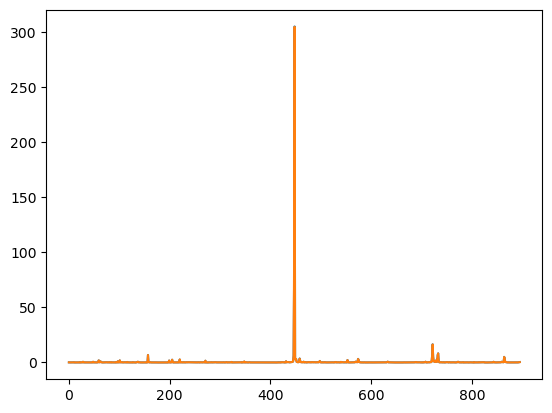

In [30]:
import matplotlib.pyplot as plt
plt.plot(out[0,:,0].cpu().numpy(), label='A')
plt.plot(out[1,:,0].cpu().numpy(), label='C')

In [ ]:
#ok this is basically identical lol. Did we actually edit it?

In [ ]:
#let's check s
s[:,:,eQTL_pos] #was a C, now is a G

tensor([[0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.]])

In [32]:
temp

label                 0
qtl_idx               0
gene_idx          10057
chrom                14
gene_start     23953734
gene_end       23969279
strand                1
qtl_loc        23953727
ref                   C
alt                   G
sign_target          -1
Name: 0, dtype: object

In [35]:
#ahh this label is a 0, let's find one that isn't
qtls

,label,qtl_idx,gene_idx,chrom,gene_start,gene_end,strand,qtl_loc,ref,alt,sign_target
0,0,0,10057,14,23953734,23969279,1,23953727,C,G,-1
1,0,0,10057,14,23953734,23969279,1,23953798,G,A,-1
2,0,0,10057,14,23953734,23969279,1,23954373,A,G,-1
3,0,0,10119,1,2555639,2565382,1,2557169,T,C,1
4,0,0,10119,1,2555639,2565382,1,2568341,G,A,1
...,...,...,...,...,...,...,...,...,...,...,...
1326,1,0,9772,3,12484421,12541549,1,12484507,G,A,1
1327,1,0,9844,14,22773222,22829820,-1,22803905,T,C,1
1328,1,0,9854,9,71911510,71986054,1,71941892,A,G,1
1329,1,0,9921,1,111117163,111140203,-1,111139496,C,T,-1


In [36]:
temp = qtls.iloc[1330]
chrom   = 'chrX' if temp['chrom']==23 else 'chr'+str(temp['chrom'])
pos     = temp['qtl_loc'] - 1  # Convert to zero-based index
gene_idx= temp['gene_idx']
tss_loc = geneTSS_dic[ordered_genes[gene_idx]]

start = tss_loc - length//2
end = tss_loc + length//2

#let's get eqtl position
eQTL_pos = pos - start
if 0 <= eQTL_pos < length:
    2
else:
    print('error')

idx = evals.dataset.expand_seqs(chrom,start,end)

In [37]:
((s,a),(su,au)) = evals.dataset[idx]
s = s.unsqueeze(0).repeat(2, 1, 1)
a = a.unsqueeze(0).repeat(2, 1, 1)
#now we can edit the input sequence
current_nuc = s[0, :, eQTL_pos].cpu().numpy()
current_nuc = np.argmax(current_nuc)
current_nuc = onehot_mapping[current_nuc]

In [ ]:
current_nuc #also correct!

'G'

In [39]:
s[1, :4, eQTL_pos] = mapping[temp['alt']]
data = ((s,a),(None,None))
out = evals(data=data)
print(out.shape) #the output of the pooled data!

torch.Size([2, 896, 1])


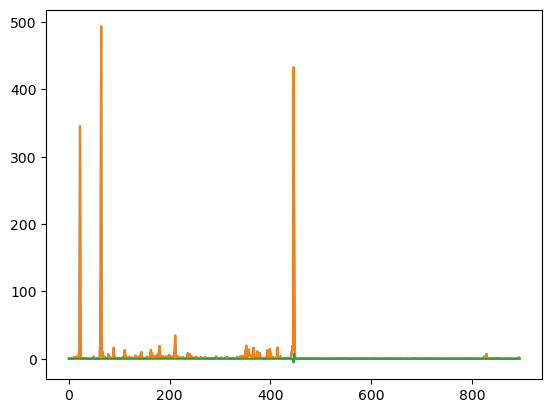

In [42]:
plt.plot(out[0,:,0].cpu().numpy(), label='A')
plt.plot(out[1,:,0].cpu().numpy(), label='C')
plt.plot(out[0,:,0].cpu().numpy() - out[1,:,0].cpu().numpy(), label='diff') #ok we have some differences, even if it's this weird thing of shifting it over more than anything?

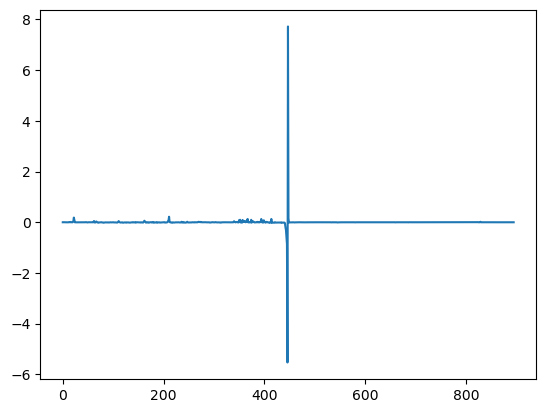

In [ ]:
plt.plot(out[0,:,0].cpu().numpy() - out[1,:,0].cpu().numpy(), label='diff') #ok we have some differences, even if it's this weird thing of shifting it over more than anything?

In [44]:
#let's make sure other than that it's the same?

s[0,:,eQTL_pos], s[1,:,eQTL_pos] #yup, just the one nucleotide is different

(tensor([0., 0., 1., 0., 0., 0.]), tensor([1., 0., 0., 0., 0., 0.]))

In [45]:
#let's make sure the rest is the same
diff = s[0].cpu().numpy() - s[1].cpu().numpy()
diff.shape

(6, 524288)

In [50]:
diff.sum(0)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [47]:
#find the non zero values of the sum
non_zero_diff = np.where(diff.sum(0) != 0)
non_zero_diff

(array([], dtype=int64),)

In [52]:
s.shape

torch.Size([2, 6, 524288])

In [ ]:
#wait it will be 0 even if that's the casea. Here's the easy approach
for i in range(s.shape[2]):
    if not torch.allclose(s[0,:,i], s[1,:,i]):
        print(f"Difference at position {i}: {s[0,:,i]} vs {s[1,:,i]}") #is indeed a G to A, just a bad example I guess?

Difference at position 261973: tensor([0., 0., 1., 0., 0., 0.]) vs tensor([1., 0., 0., 0., 0., 0.])


In [55]:
eQTL_pos

261973

In [57]:
temp = qtls.iloc[1329]
chrom   = 'chrX' if temp['chrom']==23 else 'chr'+str(temp['chrom'])
pos     = temp['qtl_loc'] - 1  # Convert to zero-based index
gene_idx= temp['gene_idx']
tss_loc = geneTSS_dic[ordered_genes[gene_idx]]

start = tss_loc - length//2
end = tss_loc + length//2

#let's get eqtl position
eQTL_pos = pos - start
if 0 <= eQTL_pos < length:
    2
else:
    print('error')

idx = evals.dataset.expand_seqs(chrom,start,end)
((s,a),(su,au)) = evals.dataset[idx]
s = s.unsqueeze(0).repeat(2, 1, 1)
a = a.unsqueeze(0).repeat(2, 1, 1)
#now we can edit the input sequence
current_nuc = s[0, :, eQTL_pos].cpu().numpy()
current_nuc = np.argmax(current_nuc)
current_nuc = onehot_mapping[current_nuc]
s[1, :4, eQTL_pos] = mapping[temp['alt']]
data = ((s,a),(None,None))
out = evals(data=data)
print(out.shape) #the output of the pooled data!

torch.Size([2, 896, 1])


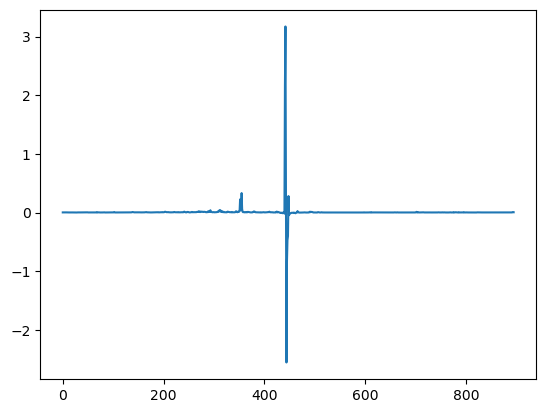

In [58]:
plt.plot(out[0,:,0].cpu().numpy() - out[1,:,0].cpu().numpy(), label='diff') #ok we have some differences, even if it's this weird thing of shifting it over more than anything?

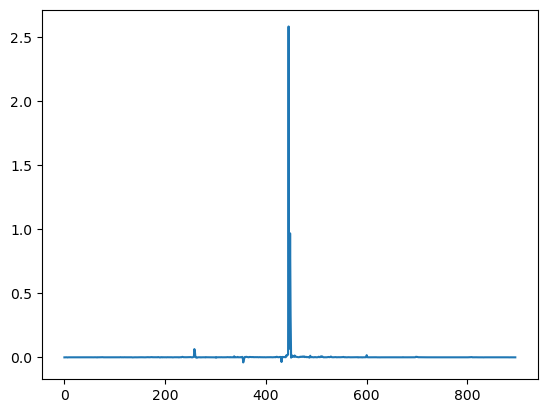

In [59]:
temp = qtls.iloc[1320]
chrom   = 'chrX' if temp['chrom']==23 else 'chr'+str(temp['chrom'])
pos     = temp['qtl_loc'] - 1  # Convert to zero-based index
gene_idx= temp['gene_idx']
tss_loc = geneTSS_dic[ordered_genes[gene_idx]]

start = tss_loc - length//2
end = tss_loc + length//2

#let's get eqtl position
eQTL_pos = pos - start
if 0 <= eQTL_pos < length:
    2
else:
    print('error')

idx = evals.dataset.expand_seqs(chrom,start,end)
((s,a),(su,au)) = evals.dataset[idx]
s = s.unsqueeze(0).repeat(2, 1, 1)
a = a.unsqueeze(0).repeat(2, 1, 1)
#now we can edit the input sequence
current_nuc = s[0, :, eQTL_pos].cpu().numpy()
current_nuc = np.argmax(current_nuc)
current_nuc = onehot_mapping[current_nuc]
s[1, :4, eQTL_pos] = mapping[temp['alt']]
data = ((s,a),(None,None))
out = evals(data=data)
plt.plot(out[0,:,0].cpu().numpy() - out[1,:,0].cpu().numpy(), label='diff') #ok we have some differences, even if it's this weird thing of shifting it over more than anything?

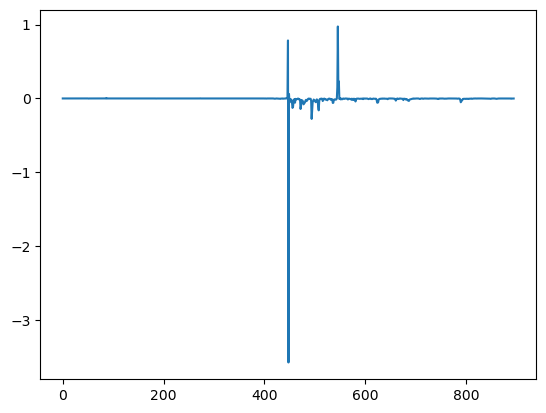

In [61]:
#ok so we have some that are indeed different, idk what's up it's weird
temp = qtls.iloc[1300]
chrom   = 'chrX' if temp['chrom']==23 else 'chr'+str(temp['chrom'])
pos     = temp['qtl_loc'] - 1  # Convert to zero-based index
gene_idx= temp['gene_idx']
tss_loc = geneTSS_dic[ordered_genes[gene_idx]]

start = tss_loc - length//2
end = tss_loc + length//2

#let's get eqtl position
eQTL_pos = pos - start
if 0 <= eQTL_pos < length:
    2
else:
    print('error')

idx = evals.dataset.expand_seqs(chrom,start,end)
((s,a),(su,au)) = evals.dataset[idx]
s = s.unsqueeze(0).repeat(2, 1, 1)
a = a.unsqueeze(0).repeat(2, 1, 1)
#now we can edit the input sequence
current_nuc = s[0, :, eQTL_pos].cpu().numpy()
current_nuc = np.argmax(current_nuc)
current_nuc = onehot_mapping[current_nuc]
s[1, :4, eQTL_pos] = mapping[temp['alt']]
data = ((s,a),(None,None))
out = evals(data=data)
plt.plot(out[0,:,0].cpu().numpy() - out[1,:,0].cpu().numpy(), label='diff')